In [1]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold,RepeatedKFold
import lightgbm as lgb
import numpy as np
from sklearn.metrics import roc_auc_score

## load data

In [2]:
train_df = pd.read_parquet('./tmp_data/train_df.parquet')
test_df = pd.read_parquet('./tmp_data/test_df.parquet')

## feature engineering

In [11]:
w2v_feats_df = pd.read_parquet('./tmp_data/w2v_feats.parquet')

In [12]:
w2v_feats = ['var_34', 'var_80', 'var_9', 'var_108', 'var_13', 'var_94',
       'var_184', 'var_1', 'var_53', 'var_22', 'var_2', 'var_12',
       'var_146', 'var_99', 'var_133', 'var_166', 'var_21', 'var_6',
       'var_165', 'var_154', 'var_174', 'var_198', 'var_76', 'var_78',
       'var_109', 'var_173', 'var_148', 'var_75', 'var_179', 'var_33',
       'var_92', 'var_123', 'var_190', 'var_127', 'var_169', 'var_87',
       'var_164', 'var_170', 'var_122', 'var_191']

In [13]:
w2v_feat_list = [c for c in w2v_feats_df.columns if c not in w2v_feats]

In [14]:
train_df = pd.concat([train_df, w2v_feats_df[w2v_feat_list][:200000]], axis=1)

In [15]:
test_df = pd.concat([test_df, w2v_feats_df[w2v_feat_list][:200000]], axis=1)

## params

In [19]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.335,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.041,
    'learning_rate': 0.0083,
    'max_depth': -1,
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'reg_alpha': 0.3,
    'reg_lambda': 0.3,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': -1
}

## k folds

In [ ]:
num_folds = 11
features = [c for c in train_df.columns if c not in ['ID_code', 'target']]

folds = StratifiedKFold(n_splits=num_folds, shuffle=False, random_state=2319)
oof = np.zeros(len(train_df))
target = train_df['target']
predictions = np.zeros(len(target))
feature_importance_df = pd.DataFrame()

print('Light GBM Model')
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
    print("Fold idx:{}".format(fold_ + 1))
    trn_data = lgb.Dataset(train_df.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train_df.iloc[val_idx][features], label=target.iloc[val_idx])
    
    
    clf = lgb.train(param, trn_data, 1000000, valid_sets = [trn_data, val_data], verbose_eval=5000, early_stopping_rounds = 4000)
    oof[val_idx] = clf.predict(train_df.iloc[val_idx][features], num_iteration=clf.best_iteration)
    predictions += clf.predict(test_df[features], num_iteration=clf.best_iteration) / folds.n_splits
    
    # feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

Light GBM Model
Fold idx:1
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.924908	valid_1's auc: 0.893217
[10000]	training's auc: 0.944897	valid_1's auc: 0.897603


In [ ]:
Light GBM Model
Fold idx:1
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.924968	valid_1's auc: 0.898085
[10000]	training's auc: 0.940653	valid_1's auc: 0.900676
[15000]	training's auc: 0.953383	valid_1's auc: 0.901326
Early stopping, best iteration is:
[14831]	training's auc: 0.952979	valid_1's auc: 0.901391
Fold idx:2
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.925306	valid_1's auc: 0.896726
[10000]	training's auc: 0.940849	valid_1's auc: 0.898372
[15000]	training's auc: 0.953511	valid_1's auc: 0.898136
Early stopping, best iteration is:
[12177]	training's auc: 0.946573	valid_1's auc: 0.898442
Fold idx:3
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.925721	valid_1's auc: 0.890335
[10000]	training's auc: 0.941187	valid_1's auc: 0.893057
[15000]	training's auc: 0.953831	valid_1's auc: 0.892903
Early stopping, best iteration is:
[12618]	training's auc: 0.948088	valid_1's auc: 0.893446
Fold idx:4
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.924987	valid_1's auc: 0.900474
[10000]	training's auc: 0.940479	valid_1's auc: 0.901999
Early stopping, best iteration is:
[8469]	training's auc: 0.936145	valid_1's auc: 0.902149
Fold idx:5
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.925226	valid_1's auc: 0.896676
[10000]	training's auc: 0.940746	valid_1's auc: 0.898578
Early stopping, best iteration is:
[10190]	training's auc: 0.94125	valid_1's auc: 0.898678
Fold idx:6
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.925136	valid_1's auc: 0.899527
[10000]	training's auc: 0.940676	valid_1's auc: 0.900933
[15000]	training's auc: 0.953376	valid_1's auc: 0.900839
Early stopping, best iteration is:
[12005]	training's auc: 0.945972	valid_1's auc: 0.901222
Fold idx:7
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.924739	valid_1's auc: 0.904726
[10000]	training's auc: 0.940341	valid_1's auc: 0.90578
Early stopping, best iteration is:
[9302]	training's auc: 0.938379	valid_1's auc: 0.905866
Fold idx:8
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.925299	valid_1's auc: 0.896506
[10000]	training's auc: 0.940921	valid_1's auc: 0.898373
Early stopping, best iteration is:
[9882]	training's auc: 0.9406	valid_1's auc: 0.898457
Fold idx:9
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.92505	valid_1's auc: 0.90162
[10000]	training's auc: 0.94066	valid_1's auc: 0.903751
Early stopping, best iteration is:
[9795]	training's auc: 0.940078	valid_1's auc: 0.903808
Fold idx:10
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.924757	valid_1's auc: 0.903197
[10000]	training's auc: 0.940368	valid_1's auc: 0.904774
[15000]	training's auc: 0.953116	valid_1's auc: 0.905003
Early stopping, best iteration is:
[12685]	training's auc: 0.947449	valid_1's auc: 0.905076
Fold idx:11
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.925291	valid_1's auc: 0.898331
[10000]	training's auc: 0.940855	valid_1's auc: 0.9
Early stopping, best iteration is:
[10853]	training's auc: 0.94319	valid_1's auc: 0.900113
CV score: 0.90059 

## feature importance

In [5]:
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.style.use('ggplot')
import seaborn as sns

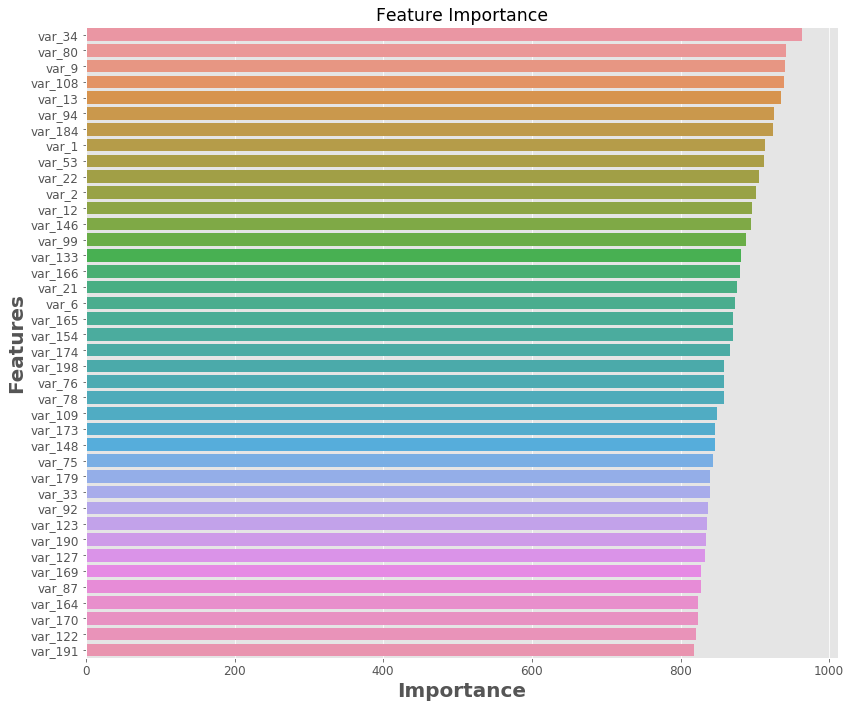

In [8]:
# Plot feature importances
cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(
    by="importance", ascending=False)[:40].reset_index()
plt.rcParams['font.size'] = 12
plt.rcParams["font.weight"] = "normal"
plt.rcParams["axes.labelweight"] = "normal"
plt.figure(figsize=(12,10))
sns.barplot(x="importance", y="feature", data=cols)
plt.title('Feature Importance')
plt.xlabel('Importance',fontweight='bold',fontsize=20)
plt.ylabel('Features',fontweight='bold',fontsize=20)
plt.tight_layout()

In [9]:
cols.feature.unique()

array(['var_34', 'var_80', 'var_9', 'var_108', 'var_13', 'var_94',
       'var_184', 'var_1', 'var_53', 'var_22', 'var_2', 'var_12',
       'var_146', 'var_99', 'var_133', 'var_166', 'var_21', 'var_6',
       'var_165', 'var_154', 'var_174', 'var_198', 'var_76', 'var_78',
       'var_109', 'var_173', 'var_148', 'var_75', 'var_179', 'var_33',
       'var_92', 'var_123', 'var_190', 'var_127', 'var_169', 'var_87',
       'var_164', 'var_170', 'var_122', 'var_191'], dtype=object)

## export results

In [10]:
num_sub = 2
print('Saving the Submission File')
sub = pd.DataFrame({"ID_code": test_df.ID_code.values})
sub["target"] = predictions
sub.to_csv('../results/submission{}.csv'.format(num_sub), index=False)

Saving the Submission File
